# Language Classification

## Overview

My aim here is to build a language classifier for EU languages.

Proposed Approach:
1. Inspect test set
1. Create dataset for training / validation
1. Train / valid split
1. Numericalize
1. Create embeddings
1. Build language classification model

## Setup

In [ ]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [163]:
from pathlib import Path
import pandas as pd
import sys
from tqdm import tqdm
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import numpy as np

from collections import Counter
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [3]:
np.random.seed(1)

In [4]:
def word_count(x): return len(x.split())
def sentence_count(x): return len(x.split('<eos>')) - 1

In [5]:
def preprocess(txt):
    
    '''Generic preprocessing: remove uninformative text, replace numbers,
    create end of sentence tokan, replace punctuation, collapse white space.'''
    
    punct = '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~'

    # Remove stuff inside brackets: <>
    # Brackets contain uninformative items for our classifier. 
    # Example: '<CHAPTER ID="008">\nCorrections to ...' 
    txt = re.sub('\<.*?\>', '', txt, count = 0)

    # Replace numbers with special character
    txt = re.sub('[0-9]+', ' <num> ', txt, count = 0)
    txt = txt.replace(' <num> .', ' <num> ')

    # Create special character for sentence end
    txt = txt.replace('.', ' <eos> ')
    txt = txt.replace('?', ' <eos> ')
    txt = txt.replace('!', ' <eos> ')
    txt = txt.replace('\n', ' <eos> ')
    txt = txt + ' <eos> '
    txt = re.sub('( <eos> )+', ' <eos> ', txt)

    # Replace all punctuation with special character
    txt = txt.translate(str.maketrans(punct, '_'*len(punct)))
    txt = txt.replace('_', ' <punct> ')

    # Collapse neighboring spaces
    txt = re.sub('[ ]+', ' ', txt, count = 0)
    
    return txt.strip()

## Settings

In [208]:
PATH = Path('train_sampl')
TEST_FN = Path('europarl.test')
PATH_TMP = Path('tmp')

MIN_FREQ = 20

BS = 64

EMB_SZ = 1000

LANGS = list(map(lambda x: x.name, list(PATH.iterdir())))

In [ ]:
PATH_TMP.mkdir(parents=True, exist_ok=True)

## Clarify Goal

In [7]:
test = pd.read_csv(TEST_FN, sep = '\t', lineterminator='\n', header=None)
test.rename({0:'label', 1:'text'}, axis = 1, inplace=True)
test['text'] = test['text'].apply(preprocess)

In [8]:
test[test['label']=='en'].iloc[345]["text"]

'I would like to thank my fellow Members for voting in favour of this report <eos>'

In [9]:
test[test['label']=='de'].iloc[345]["text"]

'Dieses Abkommen ist ein Vorbild für ähnliche Abkommen dieser Art <eos> Das ist eine Art von Abkommen <punct> die die Welt nicht ärmer machen wird <punct> die den Menschen nicht die von einigen durchaus befürworteten <punct> Freuden <punct> der nordkoreanischen Wirtschaft bringen wird <punct> sondern die den Wohlstand der Welt fördern und dazu beitragen dürfte <punct> dass wir unsere Umwelt besser schützen und für mehr politische Stabilität als ohne ein solches Abkommen sorgen werden <eos>'

In [10]:
test['text'].apply([sentence_count, word_count, len]).describe()

,sentence_count,word_count,len
count,20828.000000,20828.000000,20828.000000
mean,1.113837,26.071922,175.205541
std,0.851456,25.298060,167.062078
min,1.000000,3.000000,22.000000
25%,1.000000,15.000000,99.000000
50%,1.000000,23.000000,154.000000
75%,1.000000,33.000000,224.000000
max,77.000000,2184.000000,14069.000000


## Preprocess Dataset

In [11]:
def concat_str(lang):
    '''Helper function, not self-contained!'''
    res = ''
    fns = list((PATH/lang).glob('*.txt'))
    for fn in fns:
        res = res + fn.read_text()
    return res

In [12]:
res = concat_str('en')

In [13]:
res[:500]

'<CHAPTER ID="008">\nCorrections to votes and voting intentions: see Minutes\n<CHAPTER ID="009">\nWelcome\n<SPEAKER ID="257" NAME="President">\nLadies and gentlemen, I should like to welcome you to the afternoon sitting. The sitting is resumed and is the last sitting before the Christmas break and the New Year. I would like to take this opportunity to welcome the Executive Committee of the German War Graves Commission (Volksbund Deutsche Kriegsgräberfürsorge) from Baden-Württemberg under its chair, Mr'

In [14]:
def txt2list(txt, min_chars = 10):
    
    '''Preprocess text, and convert to list of sentences.'''
    
    res = preprocess(txt)
    res = res.strip().split('<eos>')
    
    # We also want to remove items consting only of whitespace and numbers
    res = list(map(lambda x: x.strip(), res))
    
    # Note for the minimum size: ' <eos> ' is already 7 long
    res = list(filter(lambda x: x != '' and x != '<num>' and len(x) >= min_chars, res))
    res = list(map(lambda x: x + ' <eos>', res))
    
    return res

In [15]:
res = txt2list(res)

In [16]:
res[:5]

['Corrections to votes and voting intentions <punct> see Minutes <eos>',
 'Ladies and gentlemen <punct> I should like to welcome you to the afternoon sitting <eos>',
 'The sitting is resumed and is the last sitting before the Christmas break and the New Year <eos>',
 'I would like to take this opportunity to welcome the Executive Committee of the German War Graves Commission <punct> Volksbund Deutsche Kriegsgräberfürsorge <punct> from Baden <punct> Württemberg under its chair <punct> Mr Nothelfer <eos>',
 'Based in Baden <punct> Württemberg <punct> the Commission tends the graves of <num> <num> victims of war and tyranny in Baden <punct> Württemberg alone <eos>']

In [17]:
def concat_random(txt, p = 0.02):
    
    '''At random locations (probability p), concatenate two neighboring sentences.'''
    
    idxs = np.random.choice(range(len(txt) - 1), size = int(p*len(txt)), replace=False)
    
    for i in idxs:
        txt[i + 1] = txt[i] + ' ' + txt[i + 1]
        
    res = [x for i,x in enumerate(txt) if i not in idxs] 
    
    return res

In [18]:
dfs = []
for lang in LANGS:
    print(' '+lang+' ', end = "")
    txt = concat_random(txt2list(concat_str(lang)))
    temp_df = pd.DataFrame({'text':txt})
    temp_df['label'] = lang
    dfs.append(temp_df)
df = pd.concat(dfs)[['label', 'text']]
df.reset_index(inplace=True, drop = True)

 nl  lv  es  el  cs  sl  it  fr  pt  fi  lt  da  et  de  ro  bg  pl  sv  en  hu  sk 

In [19]:
df.head()

,label,text
0,nl,Stemmingen <eos>
1,nl,Kolejnym punktem porządku jest głosowanie <eos>
2,nl,<punct> Wyniki i inne szczegóły głosowania <pu...
3,nl,Europese betalingsbevelprocedure <punct> debat...
4,nl,Aan de orde is de aanbeveling voor de tweede l...


In [20]:
df['text'].apply([sentence_count, word_count, len]).describe()

,sentence_count,word_count,len
count,295313.000000,295313.000000,295313.000000
mean,1.020155,25.264164,167.090809
std,0.141802,16.339356,108.434434
min,1.000000,2.000000,16.000000
25%,1.000000,14.000000,90.000000
50%,1.000000,22.000000,146.000000
75%,1.000000,33.000000,219.000000
max,4.000000,406.000000,2839.000000


## Train Test Split

In [21]:
len(df)

295313

In [22]:
X_train, X_val, y_train, y_val = train_test_split(np.array(df['text']), np.array(df['label']), 
                                                  test_size=0.01, random_state=42)

In [23]:
y_train

array(['nl', 'fi', 'it', ..., 'pt', 'fi', 'fr'], dtype=object)

## Numericalize

In [24]:
words = Counter()
for row in X_train: words.update(row.split())
words.most_common(10)

[('<punct>', 568131),
 ('<eos>', 298223),
 ('de', 146008),
 ('a', 68698),
 ('<num>', 59300),
 ('the', 56301),
 ('la', 51781),
 ('en', 51554),
 ('in', 49916),
 ('que', 40145)]

In [26]:
words = {k:v for k, v in words.items() if v >= MIN_FREQ}
words = sorted(words, key=words.get, reverse=True)
words = ['<unk>','<pad>'] + words

In [36]:
vocab_size = len(words)

In [28]:
word2idx = defaultdict(lambda: 0, {o:i for i,o in enumerate(words)})
idx2word = defaultdict(lambda: '<unk>', {i:o for i,o in enumerate(words)})

In [31]:
print([word2idx[w] for w in X_train[0].split()])

[221, 2177, 4, 770, 49, 30, 632, 32635, 74, 25, 1645, 15, 1853, 23634, 9, 25977, 7652, 235, 148, 2, 264, 223, 2230, 112, 25, 3914, 82, 4, 0, 127, 68, 15, 4417, 148, 14635, 3]


In [32]:
def numericalize(X, word2idx, maxlen = 50):
    m = X.shape[0]
    res = np.ones((m, maxlen))
    for row in range(m):
        temp = np.array([word2idx[w] for w in X[row].split()])
        n = min(len(temp), maxlen)
        res[row, :n] = temp[:n]
    return res.astype(np.int32)

In [33]:
X_train = numericalize(X_train, word2idx)
X_val = numericalize(X_val, word2idx)

In [34]:
def de_numericalize(X, idx2word):
    res = []
    for row in range(X.shape[0]):
        res.append(' '.join([idx2word[i] for i in X[row][X[row] != 1]]))
    return res

In [35]:
de_numericalize(X_train[:3], idx2word)

['Ik deel de mening dat er nationale strategieën voor het proces van Lissabon uitgewerkt en consequent uitgevoerd moeten worden <punct> maar deze mogen met het oog op de <unk> niet los van elkaar worden ontwikkeld <eos>',
 '<unk> kilpailun <unk> vaatimukset <unk> artiklan taloudellisen <unk> ja oikeudellisen <unk> <eos>',
 'Per questa ragione mi <unk> che il Parlamento possa nuovamente lanciare un appello per l <punct> <unk> di una forza <unk> <eos>']

## Create Embeddings

In [37]:
m, n = X_train.shape

In [38]:
idx_freq = Counter()
for row in X_train: idx_freq.update(row)
idx_freq = np.array([idx_freq[i] for i in range(len(idx_freq))]).astype(np.int32)

In [39]:
def subsamp_disc_prob(idx_freq):
    '''Creates an index of discard probabilities for the skip-gram subsampling.'''
    const = 1e-5  # From Mikolov et al 2013
    rel_freq = idx_freq / (np.sum(idx_freq) - idx_freq[1])
    rel_freq[1] = 1  # We treat padding separately, otherwise it skews freq distribution
    disc_prob = 1 - np.sqrt(np.minimum(const / rel_freq, 1))
    return disc_prob

In [40]:
[(x, subsamp_disc_prob(idx_freq)[word2idx[x]]) for x in ['the', 'in', 'of', 'president', 'approval', 'origin']]

[('the', 0.9635571556933543),
 ('in', 0.9614200959681023),
 ('of', 0.9493247551848537),
 ('president', 0.42553547891857724),
 ('approval', 0.02309071211460123),
 ('origin', 0.0)]

In [41]:
def negsamp_prob(idx_freq):
    const = 3/4  # From Mikolov et al 2013
    rel_freq = idx_freq / (np.sum(idx_freq))
    rel_freq[1] = 0.01  # Manually assign 1% prob to padding
    rel_freq = rel_freq ** const
    rel_freq = rel_freq / np.sum(rel_freq)
    return rel_freq

In [256]:
def skipgram_data(X, idx_freq, k = 5, as_tensor = True):
    
    m, n = X.shape

    # Create correct context-target pairs
    context_idx = np.random.randint(0, n, size = m)
    target_idx = np.random.randint(1, k, size = m)
    target_idx = (np.random.randint(0, 2, size = m)*2-1)*target_idx + context_idx
    target_idx = np.minimum(np.maximum(target_idx, 0), n-1)
    context = X[range(m), context_idx]
    target = X[range(m), target_idx]
    
    # Discard frequent words
    disc_prob = subsamp_disc_prob(idx_freq)
    keep_mask = (np.random.rand(m) > disc_prob[context])
    context = context[keep_mask]
    target = target[keep_mask]
    
    correct_num, fake_num, total  = (len(context), len(context)*5, len(context)*6)

    # Create incorrect pairs
    neg_samp_p = negsamp_prob(idx_freq)
    fake_target = np.random.choice(len(idx_freq), fake_num, p=neg_samp_p)
    fake_context = np.repeat(context, k)
    
    # Concatenate all
    context = np.concatenate((context, fake_context)).reshape((total, 1))
    target = np.concatenate((target, fake_target)).reshape((total, 1))
    X_res = np.concatenate((context, target), axis = 1)
    
    # Classification target
    y = np.concatenate((np.ones(correct_num), np.zeros(fake_num)))

    # Shuffle data
    shufl = np.random.permutation(total)
    X_res, y = (X_res[shufl], y[shufl])
    
    if as_tensor:   # Convert to pytorch tensor
        X_res = torch.from_numpy(X_res).type(torch.int64)
        y = torch.from_numpy(y).type(torch.float32)

    return (X_res, y)

In [264]:
X_skip, y_skip = skipgram_data(X_train, idx_freq)

In [152]:
skip_dl = DataLoader(TensorDataset(X_skip, y_skip), batch_size=BS)

In [141]:
class skip_model(nn.Module):
    def __init__(self, emb_sz = EMB_SZ, vocab_size = vocab_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_sz)
        self.target_emb = nn.Embedding(vocab_size, emb_sz)
        self.emb.weight.data.uniform_(-0.05, 0.05)
        self.target_emb.weight.data.uniform_(-0.05, 0.05)
        
    def forward(self, x):
        context, target = x[:, 0], x[:, 1]
        context, target = self.emb(context), self.target_emb(target)
        res = (context * target).sum(1)
        res = torch.sigmoid(res)
        return res.squeeze()

In [142]:
model = skip_model()

In [161]:
loss_func = nn.BCELoss()  # Binary cross entropy loss

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''https://github.com/fastai/fastai_v1/blob/master/dev_nb/001a_nn_basics.ipynb'''
    # Note: changed this by adding yb.view(-1) to match dimensions
    loss = loss_func(model(xb), yb.view(-1))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [502]:
def loss_batch(xb, yb, model, loss_func, opt):
    '''https://github.com/fastai/fastai_v1/blob/master/dev_nb/001a_nn_basics.ipynb'''
    # Note: changed this by adding yb.view(-1) to match dimensions

    loss = loss_func(model(xb), yb.view(-1))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [520]:
class Learner(object):
    
    def __init__(self, model, loss_func, train_dl = None, valid_dl = None):
        self.model = model
        self.loss_func = loss_func
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.losses = []
    
    def lr_find(self, start = 1e-5, return_losses = False, exp_smooth = True):
        lr = start; lrs = []; losses = []
        self.model.train()
        i = 0
        for xb,yb in tqdm(self.train_dl, position=0):
            opt = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
            l = self.loss_func(self.model(xb), yb.view(-1))
            l.backward(); opt.step(); opt.zero_grad()
            if exp_smooth or i ==0:
                loss = l.detach().numpy()
            else:
                loss = 0.9*loss + l.detach().numpy()            
            lrs.append(lr), losses.append(loss)
            if i > 10 and loss > 5*np.mean(losses[:i]):
                break
            if lr > 1000:
                break
            lr = lr*1.05
            i += 1        
        f, ax = plt.subplots(figsize=(5, 5))
        ax.set(yscale = 'log', xscale = 'log')
        ax = plt.plot(lrs, losses)
        self.losses = losses
        if return_losses: return (lrs, losses)
        
    def plot_loss(self):
        f, ax = plt.subplots(figsize=(5, 5))
        ax.set(yscale = 'log')
        ax = plt.plot(self.losses)
            
    def fit(self, lr, epochs, callOn_epoch_start = None):
        
        self.opt = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        loss_list = []
        
        for epoch in range(epochs):
            
            if callOn_epoch_start:
                callOn_epoch_start()
        
            # Fit model to training data
            self.model.train()
            losses, nums = zip(*[loss_batch(xb, yb, self.model, self.loss_func, self.opt) 
                                 for xb,yb in tqdm(self.train_dl, position=0)])
            train_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
            loss_list = loss_list+list(losses)

            # Calculate loss on validation set
            if self.valid_dl != None:
                model.eval()
                with torch.no_grad():
                    losses,nums = zip(*[loss_batch(model, loss_func, xb, yb)
                                        for xb,yb in valid_dl])
                val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
            else:
                val_loss = 'N/A'
                
            print(f'Epoch {epoch}. Training loss: {train_loss}. Validation loss: {val_loss}.')
        self.losses = loss_list
            
class skipgram_Learner(Learner):
    def update_train(self):
        X_skip, y_skip = skipgram_data(X_train, idx_freq)
        self.train_dl = DataLoader(TensorDataset(X_skip, y_skip), batch_size=BS)
        
    def fit(self, lr, epochs): 
        super().fit(lr, epochs, callOn_epoch_start=self.update_train)

In [521]:
learn = skipgram_Learner(model, loss_func, skip_dl)

  1%|          | 27/5002 [00:16<50:57,  1.63it/s]

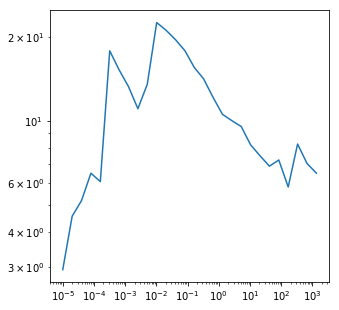

In [499]:
learn.lr_find()

In [522]:
learn.fit(0.1, 1)

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

Epoch 0. Training loss: 2.7074164867401125. Validation loss: N/A.


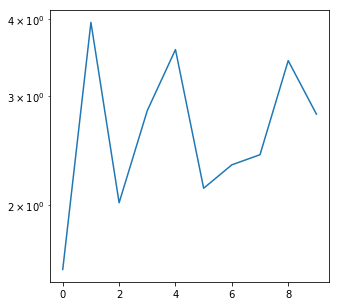

In [523]:
learn.plot_loss()

In [210]:
torch.save(sgFitter.model, PATH_TMP/'embeddings.pt')

/home/krisztian/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type skip_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [524]:
embs = sgFitter.model.emb.weight.data.numpy()

In [525]:
def cos_dist(u, v): return np.dot(u, v) / np.sqrt(np.sum(u**2)*np.sum(v**2))
def emb_pair_dist(a, b, c, d):
    return cos_dist(embs[word2idx[a]] - embs[word2idx[b]],
                   embs[word2idx[c]] - embs[word2idx[d]])

In [526]:
emb_pair_dist('man', 'woman', 'he', 'she')

0.032636125

In [527]:
emb_pair_dist('good', 'better', 'bad', 'worse')

0.0030198644